<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>
<div style="text-align:left"><a href="http://web.dmi.unict.it/"><img src="img/dmi.png" style="width:300px; margin:0;"></a></div>

<a href="http://iplab.dmi.unict.it/"><img src="img/iplab.png" style="width:900px"></a>
<center><h2>Machine Learning - A.A. 2020-2021</h2></center>
<center><h3>Transfer Learning, Autoencoders, Metric Learning</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.antoninofurnari.it/" target="_blank">http://www.antoninofurnari.it/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

In questo laboratorio vedremo alcuni concetti più avanzati di transfer learning che ci permetteranno di riutilizzare modelli pre-allenati su grandi moli di dati. Ciò permette di migliorare l'accuracy dei modelli e di ridurre i tempi di training. Vedremo inoltre alcune tecniche di "representation learning", quali autoencoders e approcci per il metric learning come le reti Siamesi e Triplet.

# 1 Transfer Learning: Fine-tuning
Il fine-tuning è la tecnica di più nota di transfer learning. Essa consiste nello specializzare un modello allenato per risolvere un determinato task per un task diverso. Ciò avviene caricando il modello pre-allenato con i rispettivi pesi, adattando la topologia della rete e "continuando" ad allenare il modello sul nuovo dataset. Abbiamo visto un esempio di questo processo nello scorso laboratorio, quando abbiamo adattato un modello allenato su CIFAR-100 per classificare le immagini di CIFAR-10.

In pratica, nel caso di inferenza a partire da immagini, si considerano spesso modelli pre-allenati su uno specifico sub-set di ImageNet (http://www.image-net.org/), un grosso dataset contenente milioni di immagini suddivise in 1000 categorie. In questo laboratorio, vedremo i passaggi necessari per adattare alcuni modelli pre-allenati su imagenet per un nuovo task.

Come task di destinazione, sceglieremo la classificazione delle immagini del dataset Caltech101, che contiene immagini suddivise in $101$ categorie. Si veda la seguente pagina per maggiori dettagli: http://www.vision.caltech.edu/Image_Datasets/Caltech101/.

## 1.1 Preparazione dei dati
Iniziamo scaricando il dataset dal seguente link: 

<center><a href='http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'>http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz</a>
</center>

Estraiamo il contenuto dell'archivio in una directory `Caltech101`. Rinominiamo dunque la cartella `101_ObjectCategories` estratta in `images`. Notiamo che `images` contiene in realtà $102$ cartelle. Ciò è dovuto al fatto che il dataset contiene anche una categoria `BACKGROUND_Google` contenente immagini di "background" non appartenenti a nessuna delle categorie in oggetto. In questo laboratorio escluderemo questa categoria. Elimiamo pertanto la cartella `BACKGROUND_Google` dall'archivio.

Otteniamo la lista delle classi (ovvero l'elenco delle sottocartelle contenute in `Caltech101/images`):

In [1]:
from glob import glob
from os.path import basename
#elenchiamo le classi
classes = glob('Caltech101/images/*')
#estraiamo il nome della classe dal path completo
classes = [basename(c) for c in classes]
print(classes)

['llama', 'ceiling_fan', 'helicopter', 'camera', 'airplanes', 'hawksbill', 'minaret', 'laptop', 'buddha', 'schooner', 'pagoda', 'cougar_body', 'metronome', 'okapi', 'kangaroo', 'BACKGROUND_Google', 'dragonfly', 'crab', 'crocodile', 'lobster', 'grand_piano', 'snoopy', 'emu', 'cellphone', 'chandelier', 'flamingo_head', 'beaver', 'mayfly', 'lamp', 'rhino', 'wheelchair', 'barrel', 'hedgehog', 'dollar_bill', 'bonsai', 'ant', 'windsor_chair', 'sunflower', 'electric_guitar', 'panda', 'brontosaurus', 'platypus', 'Faces', 'flamingo', 'ferry', 'tick', 'starfish', 'ketch', 'wild_cat', 'yin_yang', 'mandolin', 'euphonium', 'water_lilly', 'cougar_face', 'strawberry', 'gerenuk', 'dalmatian', 'watch', 'cup', 'crocodile_head', 'sea_horse', 'cannon', 'rooster', 'pizza', 'wrench', 'Motorbikes', 'ibis', 'stegosaurus', 'ewer', 'headphone', 'anchor', 'soccer_ball', 'butterfly', 'car_side', 'pyramid', 'scissors', 'octopus', 'scorpion', 'bass', 'dolphin', 'joshua_tree', 'saxophone', 'inline_skate', 'stapler',

Costruiamo adesso un dizionario che mappi le classi su id numerici. Ci servirà in seguito.

In [2]:
class_dict = {c : i for i , c in enumerate(classes)}
print(class_dict)

{'llama': 0, 'ceiling_fan': 1, 'helicopter': 2, 'camera': 3, 'airplanes': 4, 'hawksbill': 5, 'minaret': 6, 'laptop': 7, 'buddha': 8, 'schooner': 9, 'pagoda': 10, 'cougar_body': 11, 'metronome': 12, 'okapi': 13, 'kangaroo': 14, 'BACKGROUND_Google': 15, 'dragonfly': 16, 'crab': 17, 'crocodile': 18, 'lobster': 19, 'grand_piano': 20, 'snoopy': 21, 'emu': 22, 'cellphone': 23, 'chandelier': 24, 'flamingo_head': 25, 'beaver': 26, 'mayfly': 27, 'lamp': 28, 'rhino': 29, 'wheelchair': 30, 'barrel': 31, 'hedgehog': 32, 'dollar_bill': 33, 'bonsai': 34, 'ant': 35, 'windsor_chair': 36, 'sunflower': 37, 'electric_guitar': 38, 'panda': 39, 'brontosaurus': 40, 'platypus': 41, 'Faces': 42, 'flamingo': 43, 'ferry': 44, 'tick': 45, 'starfish': 46, 'ketch': 47, 'wild_cat': 48, 'yin_yang': 49, 'mandolin': 50, 'euphonium': 51, 'water_lilly': 52, 'cougar_face': 53, 'strawberry': 54, 'gerenuk': 55, 'dalmatian': 56, 'watch': 57, 'cup': 58, 'crocodile_head': 59, 'sea_horse': 60, 'cannon': 61, 'rooster': 62, 'piz

Otteniamo la lista di tutte le immagini:

In [3]:
image_paths = glob('Caltech101/*/*/*')
print(image_paths[:10])

['Caltech101/images/llama/image_0007.jpg', 'Caltech101/images/llama/image_0053.jpg', 'Caltech101/images/llama/image_0014.jpg', 'Caltech101/images/llama/image_0002.jpg', 'Caltech101/images/llama/image_0009.jpg', 'Caltech101/images/llama/image_0068.jpg', 'Caltech101/images/llama/image_0064.jpg', 'Caltech101/images/llama/image_0061.jpg', 'Caltech101/images/llama/image_0006.jpg', 'Caltech101/images/llama/image_0021.jpg']


Rimuoviamo il prefisso `Caltech1010` da ogni immagine in modo che i path facciano riferimo alla directory radice del dataset:

In [4]:
image_paths = ["/".join(p.split('/')[1:]) for p in image_paths]
print(image_paths[:10])

['images/llama/image_0007.jpg', 'images/llama/image_0053.jpg', 'images/llama/image_0014.jpg', 'images/llama/image_0002.jpg', 'images/llama/image_0009.jpg', 'images/llama/image_0068.jpg', 'images/llama/image_0064.jpg', 'images/llama/image_0061.jpg', 'images/llama/image_0006.jpg', 'images/llama/image_0021.jpg']


Scriviamo una funzione che associ la classe corretta sulla base del path:

In [5]:
def class_from_path(path):
    _, cl, _ = path.split('/')
    return class_dict[cl]

Otteniamo la lista delle etichette relative a `images`:

In [6]:
labels = [class_from_path(im) for im in image_paths]
print(labels[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Costruiamo adesso un dataframe di Pandas che contenga due colonne: una che riporta i path alle immagini, l'altra contenente le etichette.

In [7]:
import pandas as pd
dataset = pd.DataFrame({'path':image_paths, 'label':labels})
dataset.head()

,path,label
0,images/llama/image_0007.jpg,0
1,images/llama/image_0053.jpg,0
2,images/llama/image_0014.jpg,0
3,images/llama/image_0002.jpg,0
4,images/llama/image_0009.jpg,0


Il dataframe contiene adesso le informazioni che ci servono per caricare i dati da file e fare training/test degli algoritmi. Dobbiamo però suddividere il dataset in training/validation/test set. Utilizzeremo la funzione `train_test_split` di `scikit-learn` che permette di suddividere un dataframe in training e test set. Dato che a noi serve anche un validation set, applicheremo la funzione due volte. Definiamo una funzione che effettui lo split per noi:

In [8]:
from sklearn.model_selection import train_test_split
def split_train_val_test(dataset, perc=[0.6, 0.1, 0.3]):
    train, testval = train_test_split(dataset, test_size = perc[1]+perc[2])
    val, test = train_test_split(testval, test_size = perc[2]/(perc[1]+perc[2]))
    return train, val, test

Abbiamo definito la funzione in modo da utilizzare di default in 60% per training, il 10% per validation e il 30% per test. Utilizzeremo questi valori di default per il nostro split. Impostiamo un seed e effettuiamo lo split:

In [9]:
import numpy as np
import random
random.seed(1395)
np.random.seed(1359)
train, val, test = split_train_val_test(dataset)
print(len(train))
print(len(val))
print(len(test))

5487
914
2744


A questo punto salviamo i tre dataframe su csv:

In [10]:
train.to_csv('Caltech101/train.csv', index=None)
val.to_csv('Caltech101/valid.csv', index=None)
test.to_csv('Caltech101/test.csv', index=None)

Conserviamo anche un csv con le corrispondenze tra classi e id:

In [11]:
classes, ids = zip(*class_dict.items())
classes = pd.DataFrame({'id':ids, 'class':classes}).set_index('id')
classes.to_csv('Caltech101/classes.csv')

Costruiamo adesso una classe dataset che ci permetta di caricare le immagini dal disco a partire dal csv.

In [12]:
import torch
from torch.utils import data
from os.path import join
from PIL import Image

class CSVImageDataset(data.Dataset):
    def __init__(self, data_root, csv, transform = None):
        self.data_root = data_root
        self.data = pd.read_csv(csv)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        im_path, im_label = self.data.iloc[i]['path'], self.data.iloc[i].label
        #il dataset contiene alcune immagini in scala di grigi
        #convertiamo tutto in RGB per avere delle immagini consistenti
        im = Image.open(join(self.data_root,im_path)).convert('RGB')
        
        if self.transform is not None:
            im = self.transform(im)
        
        return im, im_label

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 1**

Qual è il vantaggio della struttura che abbiamo dato al dataset? (immagini in una cartella + file csv)?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 1**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Carichiamo le classi da file e trasformiamo il dataframe in un dizionario:

In [13]:
classes = pd.read_csv('Caltech101/classes.csv').to_dict()['class']

Costruiamo i dataset di training, validation e test:

In [14]:
dataset_train = CSVImageDataset('Caltech101/','Caltech101/train.csv')
dataset_valid = CSVImageDataset('Caltech101/','Caltech101/valid.csv')
dataset_test = CSVImageDataset('Caltech101/','Caltech101/test.csv')

Visualizziamo una immagine di training con la rispettiva classe:

Class id: 24 Class name: chandelier


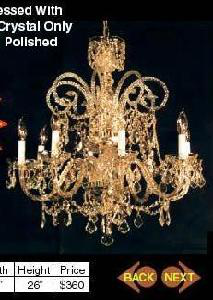

In [15]:
im, lab = dataset_train[0]
print('Class id:',lab, 'Class name:',classes[lab])
im

## 1.2 Preparazione del modello
Vediamo adesso come adattare un modello pre-allenato su Imagenet per il nostro task di classificazione. PyTorch mette a disposizione diversi modelli pre-allenati, come spiegato qui: https://pytorch.org/docs/master/torchvision/models.html. La pagina riporta anche una tabella con gli errori Top-1 e Top-5 dei vari modelli. Un modello con errori più bassi è generalmente migliore, ma i diversi modelli possono richiedere più memoria e dati di training a seconda delle loro dimensioni. Vediamo di seguito come adattare alcuni dei modelli più comuni per il nuovo task.

### AlexNet
AlexNet è la prima CNN utilizzata con successo su ImageNet. Carichiamo il modello:

In [16]:
from torchvision.models import alexnet
model = alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Il modello appena caricato è inizializzato in maniera casuale come avviene in genere quando si costruisce un nuovo modello. Se vogliamo ottenre il modello pre-allenato su ImageNet, dobbiamo costruire l'oggetto come segue:

In [17]:
model = alexnet(pretrained=True)

Alla prima esecuzione di questa riga di codice, il modello verrà automaticamente scaricato e inserito in una cache. Alle successive esecuzioni, verrà utilizzata la versione in cache. Visualizziamo nuovamente il modello: 

In [18]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Per come è costruito, il modello da in output $1000$ class scores. Il nostro problema di classificazione è però basato su $101$ classi. La prima cosa da fare per adattare il modello consiste nel ridefinire l'ultimo layer di tipo `Linear` per restituire $101$ valori. Ciò si può fare semplicemente come segue:

In [19]:
from torch import nn
model.classifier[6] = nn.Linear(4096, 101)

In [20]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### VGG16

VGG16 può essere vista come una estensione di AlexNet: la struttura è simile, ma la rete contiene molti più livelli ed è dunque sia più pesante (in termini di tempi di training e memoria richiesta) che più performante. L'adattamento di VGG16 avviene in maniera simile a quanto visto per AlexNet:

In [21]:
from torchvision.models import vgg16
model = vgg16(pretrained=True)
### adattamento
num_class = 101
model.classifier[6] = nn.Linear(4096, num_class)

### GoogleNet
GoogleNet è una rete dalle performance simili a quelle di VGG16 ma molto più compatta e veloce. La struttura della rete è diversa in quanto GoogleNet rimpiazza la maggior parte dei layer fully connected di modelli di tipo LeNet/AlexNet/VGG con convoluzioni. Carichiamo e visualizziamo il modello. Per farlo avremo bisogno di una versione di `torchvision` uguale o superiore alla `0.3`. Aggiorniamolo se necessario con: `conda upgrade torchvision`. L'adattamento avviene così:

In [22]:
from torchvision.models.googlenet import googlenet
model = googlenet(pretrained=True)
### adattamento
num_class = 101
model.fc = nn.Linear(1024, num_class)

### Resnet
Esistono diverse varianti di Resnet con diversi numeri di livelli: Resnet18, Resnet34, Resnet50, Resnet101, e Resnet152. Tutti questi modelli sono disponibili in torchvision e possono essere adattati in maniera simile. I modelli con un numero minore di livelli raggiungono accuracy minori ma sono più veloci e occupano meno spazio in memoria. Vediamo come adattare resnet18:

##### Resnet18

In [23]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
### adattamento
num_class = 101
model.fc = nn.Linear(512, num_class)
model.num_classes = num_class

### Squeezenet

Squeezenet è un modello molto compatto e veloce: occupa pochi megabyte in memoria e può essere utilizzato su CPU in fase di inferenza. Le performance di Squeezenet sono comparabili a quelle di AlexNet, che è però molto più lenta/pesante. La struttura di Squeezenet è leggermente diversa da quella degli altri modelli. Esistono più versioni di Squeezenet. Noi utilizzeremo la 1.0. L'adattamento avviene così:

In [24]:
from torchvision.models import squeezenet1_0
model = squeezenet1_0(pretrained=True)
### adattamento
num_class = 101
model.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_class

Vista la compattezza di Squeezenet, in questo laboratorio utilizzeremo questo modello. A tale scopo, costruiamo una funzione che ci permetta di caricare e modificare il modello in maniera semplice:

In [25]:
from torch import nn
from torchvision.models import squeezenet1_0

def get_model(num_class=101):
    model = squeezenet1_0(pretrained=True)
    num_class = 101
    model.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride=(1, 1))
    model.num_classes = num_class
    return model

## 1.3 Preprocessing dei dati
Tutte le reti viste sono state allenate su Imagenet e richiedono in input immagini a colori $224 \times 224$ normalizzate sottraendo determinati valori medi RGB e dividendo per determinate deviazioni standard. Questa normalizzazione si ottiene in pratica applicando la seguente normalizzazione `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`.

In pratica, in fase di training, conviene inserire data augmentation come visto negli scorsi laboratori. Definiamo la transform di training:

In [26]:
from torchvision import transforms
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In pratica:
 * `transforms.Resize(256)` ridimensiona l'immagine in input in modo che il lato più piccolo sia pari a $256$. Questa operazione serve a ridurre l'influenza della presenza di immagini a risoluzioni diverse nel dataset;
 * `transforms.RandomCrop(224)` effettua un crop quadrato casuale di dimensione $224 \times 224$;
 * `transforms.RandomHorizontalFlip()` effettua un flip orizzontale con probabilità $0.5$;
 * `transforms.ToTensor()` converte le immagini PIL in tensori di PyTorch;
 * `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])` normalizza i dati in maniera appropriata.
 
In fase di test, applichiamo una trasformazione simile ma sostituiamo `RandomCrop` con `CenterCrop`. Questo in pratica serve a far sì che la fase di test sia sempre deterministica.

In [27]:
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 2**

Come mai non abbiamo specificato `CenterCrop` anche in fase di training? Quali sarebbero i rischi di fare una cosa del genere?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 2**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Ridefiniamo il dataset includendo le transform e definiamo i dataloader. Utilizzeremo un batch size di $32$ immagini:

In [28]:
from torch.utils.data import DataLoader
caltech101_train = CSVImageDataset('Caltech101/','Caltech101/train.csv', transform = train_transform)
caltech101_valid = CSVImageDataset('Caltech101/','Caltech101/valid.csv', transform = test_transform)
caltech101_test = CSVImageDataset('Caltech101/','Caltech101/test.csv', transform = test_transform)

caltech101_train_loader = DataLoader(caltech101_train, batch_size=32, num_workers=2, shuffle=True)
caltech101_valid_loader = DataLoader(caltech101_valid, batch_size=32, num_workers=2)
caltech101_test_loader = DataLoader(caltech101_test, batch_size=32, num_workers=2)

## 1.4 Allenamento del modello
Alleniamo adesso il modello sul nuovo dataset. Definiamo una funzione per effettuare l'allenamento come visto negli scorsi laboratori. Dal momento che abbiamo suddiviso il dataset in training/validation/test set, durante il training utilizzeremo training e validation set, mentre utilizzeremo il test set verrà utilizzato solo dopo la fase di training per misurare le performance finali dell'algoritmo.

In [29]:
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join

class AverageValueMeter():
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.num = 0
    
    def add(self, value, num):
        self.sum += value*num
        self.num += num
        
    def value(self):
        try:
            return self.sum/self.num
        except:
            return None



def trainval_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99, logdir='logs'):
    criterion = nn.CrossEntropyLoss() 
    optimizer = SGD(model.parameters(), lr, momentum=momentum) 
    #meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    #inizializziamo il global step
    global_step = 0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) #"portiamoli sul device corretto"
                    y=batch[1].to(device)
                    output = model(x)
                    
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n
                    l = criterion(output,y)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    acc = accuracy_score(y.to('cpu'),output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(),n)
                    acc_meter.add(acc,n)

                    #loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
            #una volta finita l'epoca (sia nel caso di training che test, loggiamo le stime finali)
            writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
            writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)
            
        #conserviamo i pesi del modello alla fine di un ciclo di training e test
        torch.save(model.state_dict(),'%s-%d.pth'%(exp_name,e+1))
    return model

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 3**

Si confronti il codice di training con quello visto nei laboratori precedenti. Quali sono le differenze principali?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 3**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Lanciamo il training:

In [30]:
squeezenet_caltech101 = get_model()
squeezenet_caltech101_finetuned = trainval_classifier(squeezenet_caltech101, caltech101_train_loader, caltech101_valid_loader, \
                                                      exp_name='squeezenet_caltech101_finetuning', lr = 0.001, epochs = 150)

I grafici su tensorboard alla fine della procedura di training dovrebbero avere questo aspetto:

<center> <img src='img/caltech_finetune_graph.jpg' width=70%> </center>

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 4**

Possiamo dire che il modello converge? Perché?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 4**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Scriviamo adesso il codice per il test:

In [31]:
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy()
        labs = y.to('cpu').numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    return np.array(predictions), np.array(labels)

Adesso otteniamo l'accuracy di test:

In [32]:
#predizioni di test del modello all'ultima epoch
squeezenet_caltech101_finetuned_predictions_test, caltech101_labels_test = \
        test_classifier(squeezenet_caltech101_finetuned, caltech101_test_loader)

print ("Accuracy di Squeezenet su Caltech 101 - ultimo modello: %0.2f%%" % \
    (accuracy_score(caltech101_labels_test, squeezenet_caltech101_finetuned_predictions_test)*100,))

Accuracy di Squeezenet su Caltech 101 - ultimo modello: 77.30%


# 2 Autoencoder

Gli autoencoder costituiscono una categoria di algoritmi di learning di tipo "self-supervised" (auto-supervisionati). Gli autoencoder vengono utilizzati per compressione dei dati, riduzione della dimensionalità ai fini della visualizzazione e per apprendere rappresentazioni più in generale. 

Un autoencoder è una rete composta di due componenti:
 * Un encoder, che mappa i dati in uno spazio di dimensionalità inferiore. La rappresentazione ottenuta in questo livello viene generalmente detta "codice" relativo al dato in input;
 * Un decoder, che ricostruisce i dati in input a partire dal loro codice di dimensionalità inferiore.
 
Un esempio di autoencoder composto di layer fully connected è il seguente:

<center> <img src='img/autoencoder.jpg' width=70%> </center>

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 5**

Il codice dell'autoencoder ha una dimensionalità ridotta rispetto all'input. Questa è una pratica comune. Quali sarebbero i rischi di avere un codice di dimensione pari a quella di input?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 5**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Nell'esempio, l'input è di $4$ unità. L'encoder è un MLP che mappa questo input in un codice a dimensionalità inferiore pari a $2$ unità. Il decoder è un altro MLP che mappa il codice in un output della stessa dimensionalità dell'input ($4$ unità). Per ottenere un modello non lineare, alla fine di ogni livello eccetto l'ultimo viene inserita una funzione di attivazione.

Il modello viene allenato per regredire i valori di input applicando una loss di regressione (MSE) tra l'input e l'output. La cosa interessante di questo schema di training è che non è necessario di nessuna etichetta in fase di training.

Ci si aspetta che un autoencoder ben allenato sia in grado di:
 * Effettuare data compression: l'encoder può essere utilizzato per comprimere i dati, mentre il decoder può essere utilizzato per decomprimerli;
 * Effettuare dimensionality reduction: ci si aspetta che, se il decoder è capace di ricostruire il dato in input a partire dal suo codice, il codice possa essere una buona rappresentazione del dato in input;
 * Ottenere una rappresentazione utile anche per altri task (es. classificazione): ci si aspetta che il codice includa informazioni utili per la loro classificazione.

Vedremo un esempio sul dataset MNIST. Iniziamo caricando il dataset e definendo i data loader:

In [33]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,)),
                                torch.flatten]) #flatten serve per convertire le immagini in vettori di 784 unità 
mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
#drop_last=True scarta l'ultimo batch se contiene meno di batch_size immagini
#questo è utile per la parte di visualizzazione dei dati
mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=2, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2, drop_last=True)

Definiamo a questo punto un autoencoder fully connected che prenda in input le immagini sotto forma di vettori di $784$ unità, le mappi in un codice di $128$ unità e ricostruisca l'input di $784$ unità:

In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        
        #l'encoder è un MLP che mappa l'input in un codice di 128 unità
        #dato che l'ultimo livello dell'MLP non è l'ultimo della rete,
        #inseriamo una attivazione alla fine dell'MLP
        self.encoder = nn.Sequential(nn.Linear(784, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 128),
                                     nn.ReLU())
        
        #il decoder è un MLP che mappa il codice in un output di dimensione uguale all'input
        self.decoder = nn.Sequential(nn.Linear(128, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 784))
        
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        #restituiamo sia il codice che l'output ricostruito
        return code, reconstructed

Scriviamo la funzione per effettuare il training. Dato che il nostro task consiste nel ricostruire le immagini di input, stamperemo su tensorboard alcuni esempi di ricostruzione sul test set. Salveremo inoltre alcuni esempi di test ricostruiti per ogni epoca. Ciò ci permetterà di capire qualitativamente quando il modello inizia a dare buoni risultati.

In [35]:
from torchvision.utils import make_grid, save_image #per creare una griglia di immagini

def train_autoencoder(model, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99, logdir='logs'):
    #la loss di training deve essere MSE: si tratta di una loss di regresisone
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum) 
    #meters
    loss_meter = AverageValueMeter()
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    global_step = 0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test'] :
            loss_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) 
                    _, output = model(x) #output ricostruito, il codice non ci serve in fase di training
                    l = criterion(x,output)
                    
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    n = batch[0].shape[0] #numero di elementi nel batch
                    loss_meter.add(l.item(),n)

                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
            writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
            
        #alla fine di ogni epoca, stampiamo una griglia di immagini dall'ultimo batch di test
        images_in = batch[0].view(-1,1,28,28)[:50,...]
        images_out = output.view(-1,1,28,28)[:50,...]
        writer.add_image('input',make_grid(images_in, nrow=10, normalize=True), global_step=global_step)
        writer.add_image('output',make_grid(images_out, nrow=10, normalize=True), global_step=global_step)
        
        #salviamo su file gli esempi ricostruiti di test
        save_image(make_grid(images_out, nrow=5, normalize=True), 'autoencoder_reconstructed_%d.jpg'%e)
            
        #conserviamo solo l'ultimo modello sovrascrivendo i vecchi
        torch.save(model.state_dict(),'%s.pth'%exp_name)
    return model

Costruiamo l'autoencoder e lanciamo l'addestramento:

In [36]:
minst_autoencoder = Autoencoder()
minst_autoencoder = train_autoencoder(minst_autoencoder, mnist_train_loader, mnist_test_loader, exp_name='mnist_autoencoder', lr=0.01, epochs=100)

Alla fine del training, i grafici su tensorboard dovrebbero essere simili ai seguenti:

<center><img src="img/autoencoder_losses.jpg" width=70%></center>

Cliccando su "images" dovremmo riuscire a vedere le immagini di input e le relative immagini ricostruite di cui abbiamo fatto log durante il training:
<center><img src="img/autoencoder_input_output.jpg" width=70%></center>

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 6**

Si confrontino i dati ricostruiti con i dati originali. La ricostruzione è perfetta? Ci sono degli artefatti? Si confrontino i risultati ottenuti nelle iterazioni intermedie. I numeri sono sempre intellegibili?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 6**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Costruiamo adesso una funzione per estrarre i codici di tutte le immagini di test:

In [37]:
def extract_codes(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    codes, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        code, _ = model(x)
        code = code.detach().to('cpu').numpy()
        labels.append(batch[1])
        codes.append(code)
    return np.concatenate(codes), np.concatenate(labels)

Estriamo i codici insieme ai rispettivi labels che non abbiamo usato in fase di training:

In [38]:
codes, labels = extract_codes(minst_autoencoder, mnist_test_loader)
print(codes.shape, labels.shape)

(9216, 128) (9216,)


Utilizzeremo adesso una tecnica di visualizzazione dei dati chiamata TSNE (https://it.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) che permette di proiettare i dati in uno spazio a dimensione ridotta preservando le distanze relative tra gli elementi. In particolare, utilizzeremo questa tecnica per proiettare i codici di $128$ unità su due dimensioni che plotteremo sullo spazio 2D. Prima però selezioniamo un sottoinsieme dei codici da visualizzare:

In [39]:
selected_codes = np.random.choice(len(codes),1000)
codes = codes[selected_codes]
labels = labels[selected_codes]

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
codes_tsne=tsne.fit_transform(codes)

A questo punto plottiamo i codici proiettati nello spazio 2D distinguendoli per colore:

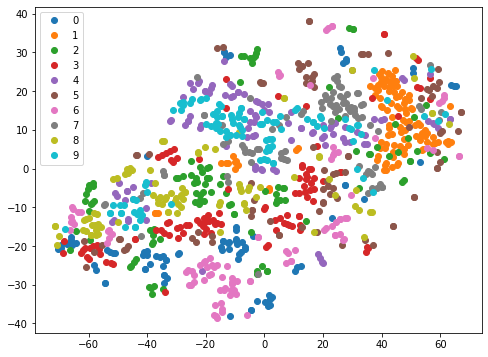

In [61]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne[labels==c, 0], codes_tsne[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 7**

Si osservi la rappresentazione TSNE dei codici estratti dall'autoencoder. I dati sono ben raggruppati per classe? Si potrebbe fare di meglio? Perché?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 7**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 2.1 Autoencoder basato su convoluzioni

E' possibile costruire un autoencoder basato su convoluzioni. In questo caso il codice non sarà un vettore unidimensionale, ma una mappa di feature di dimensionalità minore rispetto a quella in input. 

L'encoder sarà una CNN, con i seguenti accorgimenti:
 * Inseriremo il padding nelle convoluzioni per evitare di ridurre le dimensioni delle mappe di feature. L'unica operazione che ridurrà le dimensioni delle mappe di feature è il poolin;
 * Dato che il nostro obiettivo non è fare classificazione, utilizzeremo l'average pooling al posto del max pooling;
 
Il decoder sarà una CNN speculare all'encoder, con la seguente modifica:
 * Al posto dell'average pooling che riduce le dimensione dell'input di un fattore $s$, utilizzeremo un modulo di "upsampling" che, mediante interpolazione aumenterà le dimensioni dell'input di un fattore $s$;
 
Utilizzeremo solo filtri $3 \times 3$ in questo esempio. Definiamo il modello: 

In [42]:
from torch import nn
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__() 
        self.encoder = nn.Sequential(nn.Conv2d(1,16,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,8,3, padding=1),
                                     nn.AvgPool2d(2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,4,3, padding=1),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4,8,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(8,16,3, padding=1),
                                     nn.Upsample(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16,1,3, padding=1))
        
    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

Prima di allenare il modello, dobbiamo ridefinire dataset e data loaders evitando di introdurre l'operazione `flatten`, in modo da caricare immagini $28 \times 28$ invece di vettori di $784$ elementi:

In [43]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
mnist_train = MNIST(root='mnist',train=True, download=True, transform=transform)
mnist_test = MNIST(root='mnist',train=False, download=True, transform=transform)
#drop_last=True scarta l'ultimo batch se contiene meno di batch_size immagini
#questo è utile per la parte di visualizzazione dei dati
mnist_train_loader = DataLoader(mnist_train, batch_size=1024, num_workers=2, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, num_workers=2, drop_last=True)

Adesso alleniamo il modello:

In [44]:
minst_conv_autoencoder = ConvAutoencoder()
minst_conv_autoencoder = train_autoencoder(minst_conv_autoencoder, mnist_train_loader, mnist_test_loader, \
                                           exp_name='mnist_conv_autoencoder', lr=0.01, epochs=100)

Alla fine del training, i grafici su tensorboard dovrebbero essere simili ai seguenti:

<center><img src="img/conv_autoencoder_graph.jpg" width=70%></center>
<center><img src="img/autoencoder_conv_input_output.jpg" width=70%></center>


<img src="img/qmark.jpg" style="width:150px; float:left;"/>

**Domanda 8**

Si confrontino i risultati ottenuti dal nuovo modello con quelli ottenuti dal vecchio. Quali risultati appaiono migliori? A cosa può essere dovuta la differenza?

<img style="float: left;width:150px;" src="img/note.png">

**Risposta 8**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Estraiamo i codici con il nuovo autoencoder:

In [45]:
codes, labels = extract_codes(minst_conv_autoencoder, mnist_test_loader)
print(codes.shape, labels.shape)

(9216, 4, 7, 7) (9216,)


I codici sono delle mappe di feature $4 \times 7 \times 7$. Trasformiamoli in vettori monodimensionali e selezioniamo lo stesso sottoinsieme di dati considerati nel caso precedente:

In [46]:
codes = codes.reshape(codes.shape[0],-1)
codes = codes[selected_codes]
labels = labels[selected_codes]
print(codes.shape)

(1000, 196)


Traformiamo i dati mediante TSNE ed eseguiamo il plot:

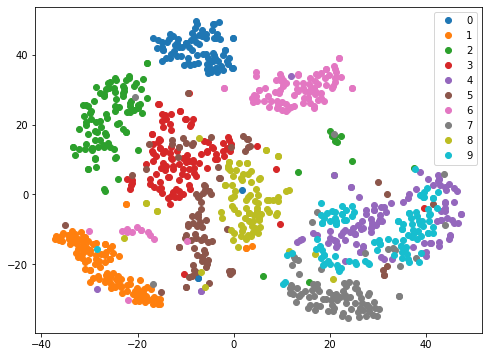

In [47]:
tsne = TSNE(2)
codes_tsne_conv=tsne.fit_transform(codes)

plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.plot(codes_tsne_conv[labels==c, 0], codes_tsne_conv[labels==c, 1], 'o', label = c)
plt.legend()
plt.show()

**Domanda 9**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confronti il grafico ottenuto con quello dell'autoencoder senza convoluzioni. Quali dei due trasforma i dati in maniera più "coerente" con le classi? Perché?

**Risposta 9**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 3 Metric Learning

Il metric learning è una tipologia di learning supervisionato che ha come obiettivo quello di apprendere una funzione distanza tra oggetti. 

Vediamo un esempio. Supponiamo di avere un database contenente immagini di volti $I_i$ con le rispettive etichette $l_i$ che indicano le identità dei soggetti ritratti nelle immagini $l_i$. Il database può essere indicato con $D=\{(I_i, l_i)\}_i^N$. Data una nuova immagine contenente un volto $I_j$ di identità sconosciuta, vorremmo poter "cercare" il nuovo volto all'interno del database al fine di inferire l'identità nel soggetto ritratto nell'immagine. Per poter effettuare questa ricerca, abbiamo bisogno di stimare la distanza tra il nuovo volto $I_j$ e tutti i volti presenti nel database $D$. Alla fine assegneremo al nuovo volto l'etichetta del volto più vicino nel database:

\begin{equation}
\hat l_j = l_{\arg \max_{i} d(I_i, I_j)}
\end{equation}

Dove $d$ è una funzione che misura la distanza tra le immagini di due volti. Questa procedura è una ricerca di tipo nearest neighbour. 

Va notato che la funzione $d$ di cui abbiamo bisogno deve avere determinate caratteristiche. In particolare, vorremmo che la distanza tra due immagini $d(I_i, I_j)$ sia grande nel caso in cui le immagini non ritraggano lo stesso soggetto ($l_i \neq l_j$) e piccola nel caso in cui le identità siano uguali ($l_i = l_j$). Definire questa funzione a mano non è banale. Ad esempio, scegliendo $d$ uguale alla distanza Euclidea, non abbiamo nessuna garanzia che le proprietà richieste vengano rispettate. L'ideale sarebbe apprendere $d$ dai dati, ma non è chiaro come costruire una funzione parametrica $d$ che prende in input due immagini.

Possiamo però vedere il problema in maniera leggermente diversa. Definiamo una funzione $\Phi$ che mappa un'immagine $I$ in uno spazio di dimensionalità limitata ($\Phi$ è simile all'encoder di un autoencoder) e ridefiniamo la funzione distanza come:

\begin{equation}
d(I_i, I_j) = ||\Phi(I_i) - \Phi(I_j)||_2
\end{equation}

Dove $||\Phi(I_i) - \Phi(I_j)||_2$ è la norma L2 del vettore differenza, che equivale a calcolare la distanza Euclidea tra $\Phi(I_i)$ e $\Phi(I_j)$. Se $\Phi$ è una funzione parametrica (es. una CNN), possiamo ottimizzare i parametri di $\Phi$ in maniera tale che $d$ rispetti le caratteristiche richieste. In pratica, stiamo fissando la metrica vera e propria (scegliendo quella Euclidea) e stiamo scegliendo di risolvere un problema leggermente diverso: trovare una funzione $\Phi$ che mappi elementi $I_i$ e $I_j$ della stassa classe ($l_i=l_j$) vicini nello spazio di destinazione ed elementi di classi diverse ($l_i \neq l_j$) lontani tra di loro nello spazio di destinazione.

Esistono diverse tecniche per determinare la funzione $\Phi$ in maniera opportuna. Noi vedremo due possibilità: la rete siamese e la rete triplet.

## 3.1 Rete Siamese

Il modo più semplice per ottenere una funzione $\Phi$ opportuna consiste nel prevedere una loss che renda la distanza $||\Phi(I_i) - \Phi(I_j)||_2$ piccola se $l_i=l_j$ e grande se $l_i \neq l_j$. Dato che l'espressione $||\Phi(I_i) - \Phi(I_j)||_2$ prende in input due elementi $I_i$ e $I_j$, conviene ragionare su coppie di elementi $(I_i, I_j)$ piuttosto che su elementi singoli. Esistono due tipi di coppie: quelle in cui le etichette dei due elementi sono uguali, e quelle in cui i le due etichette sono diverse. Chiameremo queste coppie "coppie simili" e "coppie dissimili". Assegneremo dunque ad ogni coppia una etichetta $l_{ij}$. In pratica $l_{ij}=0$ se la coppia è "simile", mentre $l_{ij}=1$ se la coppia è "dissimile". Al fine di lavorare su coppie, è possibile utilizzare una rete "siamese", ovvero un'architettura composta da due rami identici che condividono i medesimi pesi che mappano i due elementi della coppia $I_i$ e $I_j$ in due codici $\Phi(I_i)$ e $\Phi(I_j)$. Una volta ottenute queste due rappresentazioni, possiamo applicare una loss opportuna. 

Una rete Siamese può essere rappresentata come mostrato di seguito:

<center> <img src='img/siamese.jpg'> </center>

Nel grafico sopra:
 * L'input della rete non è un singolo elemento $I_i$, ma una coppia di elementi con la rispettiva etichetta: $(I_i, I_j, l_{ij})$;
 * La funzione $\Phi$ è rappresentata come un MLP. In pratica $\Phi$ può avere diverse forme, ad esempio $\Phi$ può essere una CNN;
 * I due rami (superiore e inferiore) hanno pesi condivisi. Ciò vuole dire che ogni volta il valore di uno dei pesi in una delle due reti viene aggiornato, esso viene aggiornato anche nell'altra rete;
 * I pallini azzurri rappresentano i due codici $\Phi(I_i)$ e $\Phi(I_j)$;
 * La loss utilizzata per allenare la rete $L[\Phi(I_i), \Phi(I_j),l_i,l_j]$ dipende sia dai due codici che dalle due etichette.
 
Diverse funzioni di loss sono possibili. In pratica, la loss più utilizzata è la contrastive loss, che viene definita come segue per una data coppia in input:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i)-\Phi(I_j)||_2 \\
L(I_i, I_j, l_{ij}) = \frac{1}{2}(1-l_{ij})d(I_i, I_j)^2+\frac{1}{2}l_{ij}\{max[0,m-d(I_i, I_j)]\}^2
\end{eqnarray}

dove $m$ è un parametro della loss detto "margine". La loss assomiglia a una binary cross entropy. Analizziamola:
 * Se la coppia è di tipo "simile", allora $l_{ij}=0$. In tal caso, $L(I_i,I_j,1) = \frac{1}{2}d(I_i,I_j)^2$, che risulta minimizzata quando $d(I_i, I_j)$ è piccola. Pertanto, in questo caso, $\Phi$ viene incoraggiata a mappare i due elementi in posizioni vicine tra di loro nello spazio di destinazione;
 * Se la coppia è di ditpo "dissimile", allora $l_{ij}=1$. In tal caso, $L(I_i,I_j,0) = \frac{1}{2}\{max([0, m-d(I_i, I_j)]\}^2$. Abbiamo adesso due casi:
    * $d(I_i, I_j)>m$: in tal caso $m-d(I_i, I_j)<0$ e $L(I_i,I_j,0)=0$. Pertanto, se la distanza $d(I_i, I_j)$ è superiore al margine $m$, la rete non viene penalizzata in quanto si ritiene che i due mapping sono già abbastanza lontani;
    * $d(I_i, I_j)<m$: in tal caso $m-d(I_i, I_j)>0$ e $L(I_i,I_j,0)=(m-d(I_i,I_j))^2$, e la rete riceve una penalità quadratica rispetto alla differenza tra la distanza e il margine. Se la distanza è molto piccola, la penalità sarà maggiore, se è abbastanza vicina a $m$, la penalità sarà minore.
    
In pratica, il margine $m$ stabilisce la distanza minima tra due elementi diversi nello spazio di destinazione. Esistono diversi tecniche per impostare il valore del margine. Per semplicità, in questo laboratorio imposteremo $m=2$, che è un valore comunemente usato.

### 3.1.1 Dataset
 
Per costruire la nostra rete Siamese, abbiamo innanzitutto bisogno di costruire un oggetto dataset che restituisca coppie di immagini con le rispettive etichette. Vedremo un semplice esempio relativo al dataset MNIST. Le nostre coppie saranno dunque composte da due immagini rappresentanti cifre. L'etichetta relativa sarà pari a $0$ se le etichette delle due immagini sono uguali e $1$ altrimenti. Costruiremo un oggetto database che ha tanti elementi quanti sono gli elementi di MNIST. A ciascun elemento verrà associato un elemento simile o dissimile con probabilità $\frac{1}{2}$. Ciò ci permetterà di avere un dataset di coppie bilanciato.

In [48]:
class PairMNIST(data.Dataset):
    def __init__(self, root, train = True, transform = None, download = True):
        self.mnist = MNIST(root = root, train = train, transform = transform, download = download)
        
        #lista di liste che contiene gli indici elementi appartenenti alle singole classi
        #in pratica class_to_indices[5] contiene gli indici degli elementi di classe 5
        self.class_to_indices = [np.where(self.mnist.targets == label)[0] for label in range(10)]

        #genera le coppie
        self.generate_pairs()
        
    def generate_pairs(self):
        """Genera le coppie, associando ad ogni elemento di
        MNIST un nuovo elemento"""
        #creiamo un vettore di etichette delle coppie
        self.pair_labels = (np.random.rand(len(self.mnist))>0.5).astype(int)
        
        #paired_idx conterrà i secondi elementi delle coppie
        #il primo elmento della coppia i-esima sarà sempre
        #l'elemento i-esimo di MNIST
        self.paired_idx = []
        #scorriamo le etichette delle coppie
        for i, l in enumerate(self.pair_labels):
            #otteniamo la classe del primo elemento della coppia
            c1 = self.mnist.targets[i].item()
            if l==0: #se la coppia è di tipo simile
                #scegli un elemento della stessa classe
                j = np.random.choice(self.class_to_indices[c1])
            else: #altrimenti
                #scegli un elemento di classe diversa
                #scegliamo una classe diversa a caso
                diff_class = np.random.choice(list(set(range(10))-{c1}))
                #campioniamo da quella classe
                j = np.random.choice(self.class_to_indices[diff_class])
            #conserviamo l'indice del secondo elemento della coppia
            self.paired_idx.append(j)
        
    def __len__(self):
        #tante coppie quanti sono gli elemnti di MNIST
        return len(self.mnist)
    
    def __getitem__(self, i):
        #la prima immagine della coppia
        #è l'elemento i-esimo di MNIST
        im1, l1 = self.mnist[i]
        im2, l2 = self.mnist[self.paired_idx[i]] #secondo elemento associato
        l = self.pair_labels[i] #etichetta della coppia
        
        #restituiamo le due immagini, l'etichetta della coppia
        #e le etichette delle due immagini
        return im1, im2, l, l1, l2

Costruiamo il dataset e visualizziamo qualche coppia di esempio:

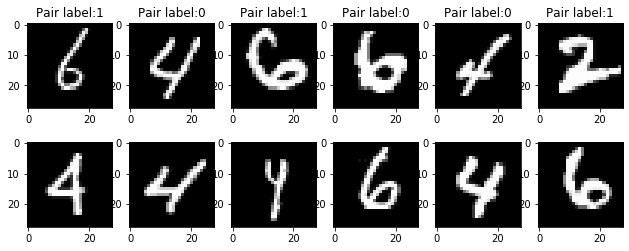

In [49]:
pair_mnist_train = PairMNIST('mnist', train=True)
plt.figure(figsize=(18,4))
for ii,i in enumerate(np.random.choice(range(len(pair_mnist_train)),6)):
    plt.subplot(2,10,ii+1)
    plt.title('Pair label:'+str(pair_mnist_train[i][2]))
    plt.imshow(pair_mnist_train[i][0], cmap='gray')
    plt.subplot(2,10,ii+11)
    plt.imshow(pair_mnist_train[i][1], cmap='gray')
plt.show()

**Domanda 10**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si osservino le coppie rappresentate nelle colonne. Ha senso dire che elementi in coppie positive sono in genere più simili di elementi in coppie negative?

**Risposta 10**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

### 3.1.2 Modello
Implementiamo $\Phi$ basandoci su LeNet. Dato che non useremo $\Phi$ per classificare i dati in input, ometteremo l'ultimo livello con $10$ unità. Chiameremo questa rete `EmbeddingNet` in quanto il suo ruolo è quello di ottenere degli embedding (o codici) delle immagini in input:

In [50]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 64, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.BatchNorm1d(64 *4 * 4),
                                nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.BatchNorm1d(256),
                                nn.Linear(256, 128))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

Verifichiamo che l'output sia quello desiderato con un batch fittizio:

In [51]:
model = EmbeddingNet()
model(torch.zeros(16,1,28,28)).shape

torch.Size([16, 128])

### 3.1.3 Funzione di loss
Prima di effettuare il training, dobbiamo implementare la funzione di loss. Ricordiamo che la loss per un dato campione è definita come segue:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i)-\Phi(I_j)||_2 \\
L(I_i, I_j, l_{ij}) = \frac{1}{2}(1-l_{ij})d(I_i, I_j)^2+\frac{1}{2}l_{ij}\{max[0,m-d(I_i, I_j)]\}^2
\end{eqnarray}

In [52]:
from torch.nn import functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d,2) + \
            0.5 * l_ij.float() * torch.pow( torch.clamp( self.m - d, min = 0) , 2)
        return l.mean()

dove `F.pairwise_distance(x,y)` calcola la distanza euclidea tra tutti gli elementi di $x$ e tutti gli elementi di $y$ quando $x$ e $y$ sono dei batch, `torch.pow(x,2)` implementa $x^2$ e `torch.clamp(x, min=0)` implementa `min(x,o)`.

### 3.1.4 Training del modello
Adesso che abbiamo tutti gli elementi necessari, scriviamo una funzione che permetta di effettuare il training della rete Siamese. Per monitorare lo stato di training della rete in termini qualitativi, alla fine di ogni epoca stamperemo l'embedding dell'ultimo batch di test.

In [53]:
def train_siamese(embedding_net, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99, margin=2, logdir='logs'):
    #definiamo la contrastive loss
    criterion = ContrastiveLoss(margin)
    optimizer = SGD(embedding_net.parameters(), lr, momentum=momentum)
    #meters
    loss_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedding_net.to(device)
    criterion.to(device)# anche la loss va portata sul device in quanto contiene un parametro (m)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    global_step=0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test'] :
            loss_meter.reset()
            embedding_net.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    I_i, I_j, l_ij, _, _ = [b.to(device) for b in batch]
                    #l'implementazione della rete siamese è banale:
                    #eseguiamo la embedding net sui due input
                    phi_i = embedding_net(I_i)
                    phi_j = embedding_net(I_j)
                    
                    #calcoliamo la loss
                    l = criterion(phi_i, phi_j, l_ij)
                    
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training
                    n = I_i.shape[0] #numero di elementi nel batch
                    global_step += n

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    n = batch[0].shape[0] #numero di elementi nel batch
                    loss_meter.add(l.item(),n)
                    
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        
            writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
            
        #aggiungiamo un embedding. Tensorboard farà il resto
        writer.add_embedding(phi_i, batch[3], I_i, global_step=global_step, tag=exp_name+'_embedding')

        #conserviamo solo l'ultimo modello sovrascrivendo i vecchi
        torch.save(model.state_dict(),'%s.pth'%exp_name)
    return model

Costruiamo dataset e data loaders:

In [54]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
pair_mnist_train = PairMNIST(root='mnist',train=True, download=True, transform=transform)
pair_mnist_test = PairMNIST(root='mnist',train=False, download=True, transform=transform)
pair_mnist_train_loader = DataLoader(pair_mnist_train, batch_size=1024, num_workers=2, shuffle=True)
pair_mnist_test_loader = DataLoader(pair_mnist_test, batch_size=1024, num_workers=2)

Costruiamo e alleniamo il modello:

In [55]:
siamese_mnist = EmbeddingNet()
siamese_mnist = train_siamese(siamese_mnist, pair_mnist_train_loader, pair_mnist_test_loader, exp_name = 'mnist_siamese', lr=0.01, epochs = 20)

Alla fine della procedura di training, i grafici su tensorboard avranno un aspetto simile a questo:

<center> <img src='img/siamese_loss.jpg' width=70%></center>

Cliccando su "projector" possiamo visualizzare un embedding 3D creato in automatico dai dati di cui abbiamo fatto log.

<center> <img src='img/siamese_embedding.jpg' width=70%></center>

**Domanda 11**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confrontino gli embedding ottenuti con quelli visti nel caso degli autoencoder. Quale modello restituisce risultati "migliori"? Perché?

**Risposta 11**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 3.2 Rete Triplet

La rete Siamese viene allenata includendo all'interno dello stesso batch sia esempi negativi che esempi positivi. Se includessimo solo esempi positivi, la rete imparerebbe a mappare qualsiasi input sullo stesso punto, in modo da ottenere sempre distanza nulla. Se includessimo solo esempi negativi, al contrario, la rete cercherebbe di mappare i nuovi campioni sempre lontani rispetto ai campioni già visti. Una rete di tipo Triplet estende l'idea di avere coppie positive e negative lavorando su triplette invece che su coppia. 

Ogni tripletta $(I_i, I_j, I_k)$ contiene tre elementi:
 * Un'ancora $I_i$, ovvero un elemento di classe qualsiasi;
 * Un esempio positivo $I_j$, ovvero un elemento della stessa classe di $I_i$;
 * Un esempio negativo $I_k$, ovvero un elemento di classe diversa rispetto a $I_i$ e $I_j$.

Ogni elemento in input presenta dunque un esempio positivo (la coppia ($I_i, I_j$)) e un esempio negativo (la coppia ($I_i, I_k$)). A differenza per quanto avveniva nel caso delle reti siamesi, le triplette non hanno una etichetta associata. Il modello viene dunque allenato facendo sì che $I_i$ venga mappato vicino a $I_j$ ma allo stesso tempo lontano da $I_k$. Ciò costituisce un criterio di training più forte rispetto a quello delle reti siamesi. Infatti, mentre le caso delle reti siamesi le coppie positive e negative potevano non avere alcuna relazione tra di esse, le triplette offrono sempre un esempio positivo e un esempio negativo relativi al medesimo elemento ancora $I_i$. 

Una rete Triplet può essere rappresentata come segue:

<center><img src='img/triplet.jpg' width=70%> </center>

Anche in questo caso i pesi delle tre reti sono condivisi. Esistono diversi tipi di loss, ma la più comune è la Triplet margin loss, definita come segue:

\begin{eqnarray}
d(I_i, I_j) = ||\Phi(I_i) - \Phi(I_j)||_2 \\
L(I_i, I_j, I_k) = \max\{d(I_i, I_j)-d(I_i, I_k)+m, 0\}
\end{eqnarray}

In maniera simile a quanto visto nel caso della contrastive loss, $m$ è un margine. In questo laboratorio imposteremo $m=1$.

La loss scritta sopra incoraggia la rete $\Phi$ a mappare l'elemento simile $I_j$ vicino all'elemento $I_i$ e al contempo, l'elemento $I_k$ lontano da $I_i$. Ciò avviene penalizzando la rete ogni volta che $d(I_i, I_j)$ non è maggiore di $d(I_i, I_k)$ di un valore almeno pari ad $m$. Abbiamo infatti due casi:
 * $d(I_i, I_j) + m <=d(I_i, I_k)$: in questo caso $d(I_i, I_j)-d(I_i, I_k)+m<0$ e $L(I_i, I_j, I_k)=0$. In pratica il modello non viene penalizzato in quanto la distanza tra l'ancora $I_i$ e l'elemento simile $I_j$ è già sufficientemente inferiore (ovver inferiore di almento $m$) alla distanza tra l'ancora $I_i$ e l'elemento dissimile $I_k$;
 * $d(I_i, I_k) +m >d(I_i, I_k)$: in questo caso $d(I_i, I_j)-d(I_i, I_k)+m>0$ e $L(I_i, I_j, I_k)=d(I_i, I_j)-d(I_i, I_k)+m$. Pertanto il modello riceve una penalità (una loss positiva) in quanto non vi è abbastanza margine tra le due distanze. La loss è tanto più alta quanto questo margine è grande.
 
Questa funzione di loss è già implementata in PyTorch da modulo `nn.TripletMarginLoss`, che utilizzeremo per i nostri esperimenti.

### 3.2.1 Dataset

Dobbiamo implementare un dataset che restituisca delle triplette di valori. L'implementazione è analoga a quanto visto nel caso delle reti siamesi:

In [56]:
class TripletMNIST(data.Dataset):
    def __init__(self, root, train = True, transform = None, download = True):
        self.mnist = MNIST(root = root, train = train, transform = transform, download = download)
        
        #lista di liste che contiene gli indici elementi appartenenti alle singole classi
        #in pratica class_to_indices[5] contiene gli indici degli elementi di classe 5
        self.class_to_indices = [np.where(self.mnist.targets == label)[0] for label in range(10)]

        #genera le triplette
        self.generate_triplets()
        
    def generate_triplets(self):
        """Genera le triplette, associando ad ogni elemento di
        MNIST due nuovi elementi: uno simile e uno dissimile"""
        
        #similar_idx conterrà i secondi elementi delle triplette
        #dissimilar_idx conterrà i terzi elementi delle triplette
        #il primo elmento della coppia i-esima sarà sempre
        #l'elemento i-esimo di MNIST
        self.similar_idx = []
        self.dissimilar_idx = []
        #scorriamo gli elementi di MNIST
        for i in range(len(self.mnist)):
            #classe del primo elemento della tripletta
            c1 = self.mnist.targets[i].item()
            #indice dell'elemento simile
            j = np.random.choice(self.class_to_indices[c1])
            
            #scegliamo una classe diversa a caso
            diff_class = np.random.choice(list(set(range(10))-{c1}))
            #campioniamo da quella classe per ottenere l'indice dell'elemento dissimile
            k = np.random.choice(self.class_to_indices[diff_class])
            
            self.similar_idx.append(j)
            self.dissimilar_idx.append(k)
        
    def __len__(self):
        #tante triplette quanti sono gli elemnti di MNIST
        return len(self.mnist)
    
    def __getitem__(self, i):
        #la prima immagine della coppia
        #è l'elemento i-esimo di MNIST
        im1, l1 = self.mnist[i]
        im2, l2 = self.mnist[self.similar_idx[i]] #elemento simile
        im3, l3 = self.mnist[self.dissimilar_idx[i]] #elemento dissimile
        
        #restituiamo le due immagini, l'etichetta della coppia
        #e le etichette delle due immagini
        return im1, im2, im3, l1, l2, l3

Costruiamo il dataset e visualizziamo qualche tripletta di esempio:

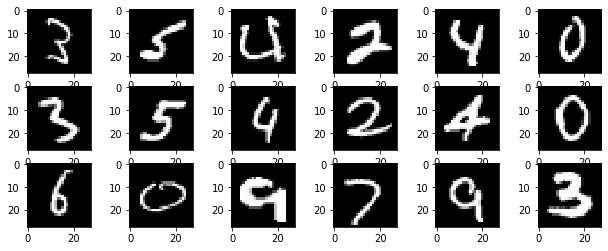

In [57]:
triplet_mnist_train = TripletMNIST('mnist', train=True)
plt.figure(figsize=(18,4))
for ii,i in enumerate(np.random.choice(range(len(triplet_mnist_train)),6)):
    plt.subplot(3,10,ii+1)
    plt.imshow(triplet_mnist_train[i][0], cmap='gray')
    plt.subplot(3,10,ii+11)
    plt.imshow(triplet_mnist_train[i][1], cmap='gray')
    plt.subplot(3,10,ii+21)
    plt.imshow(triplet_mnist_train[i][2], cmap='gray')
plt.show()

**Domanda 12**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confrontino le triplette visualizzate qui con le coppie mostrate nel caso della rete siamese. Le triplette aggiungono più difficili in fase di training?

**Risposta 12**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

### 3.2.2 Training

Definiamo una procedura di training analoga a quella vista nel caso delle reti siamesi. Anche in questo caso plotteremo gli embedding durante il training.

In [58]:
def train_triplet(embedding_net, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99, margin=1, logdir='logs'):
    #definiamo la contrastive loss
    criterion = nn.TripletMarginLoss(margin = margin)
    optimizer = SGD(embedding_net.parameters(), lr, momentum=momentum) 
    #meters
    loss_meter = AverageValueMeter()
    writer = SummaryWriter(join(logdir, exp_name))
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embedding_net.to(device)
    criterion.to(device)# anche la loss va portata sul device in quanto contiene un parametro (m)
    #definiamo un dizionario contenente i loader di training e test
    loader = {
        'train' : train_loader,
        'test' : test_loader
    }
    global_step = 0
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test'] :
            loss_meter.reset()
            embedding_net.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in training
                for i, batch in enumerate(loader[mode]):
                    I_i, I_j, I_k, _, _, _ = [b.to(device) for b in batch]
                    #l'implementazione della rete triplet è banale quanto quella della rete siamese:
                    #eseguiamo la embedding net sui tre input
                    phi_i = embedding_net(I_i)
                    phi_j = embedding_net(I_j)
                    phi_k = embedding_net(I_k)
                    
                    n = phi_i.shape[0] #numero di elementi nel batch
                    global_step += n
                    
                    #calcoliamo la loss
                    l = criterion(phi_i, phi_j, phi_k)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    n = batch[0].shape[0] #numero di elementi nel batch
                    loss_meter.add(l.item(),n)
                    
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)

            writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
        
        #aggiungiamo un embedding. Tensorboard farà il resto
        writer.add_embedding(phi_i, batch[3], I_i, global_step=global_step, tag=exp_name+'_embedding')
        
        #conserviamo solo l'ultimo modello sovrascrivendo i vecchi
        torch.save(model.state_dict(),'%s.pth'%exp_name)
    return model

Adesso definiamo i dataset e i data loader:

In [59]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))]) 
triplet_mnist_train = TripletMNIST(root='mnist',train=True, download=True, transform=transform)
triplet_mnist_test = TripletMNIST(root='mnist',train=False, download=True, transform=transform)
triplet_mnist_train_loader = DataLoader(triplet_mnist_train, batch_size=1024, num_workers=2, shuffle=True)
triplet_mnist_test_loader = DataLoader(triplet_mnist_test, batch_size=1024, num_workers=2)

Alleniamo dunque il modello. Utilizzeremo la stessa rete di base `EmbeddingNet` come funzione $\Phi$.

In [60]:
triplet_mnist = EmbeddingNet()
triplet_mnist = train_triplet(triplet_mnist, triplet_mnist_train_loader, triplet_mnist_test_loader, exp_name = 'mnist_triplet', lr=0.01, epochs = 20)

**Domanda 13**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confrontino gli embedding ottenuti mediante la rete triplet con quelli ottenuti mediante la rete siamese? Ci sono differenze? Si osservi l'evolversi degli embedding nei due casi. In uno dei due casi la rete sembra convergere pirma?

**Risposta 13**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# Esercizi
<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

**Esercizio 1**

Si adatti la funzione `get_model` in modo che essa prenda in input un parametro `model_architecture` che indichi l'architettura di CNN da adattare (es., AlexNet, VGG16, ecc...). La funzione deve restituire un modello dell'architettura specificata opportunamente adattato per il nuovo task.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

**Esercizio 2**

Si adatti l'autoencoder basato su convoluzioni per effettuare la classificazione dei dati di MNIST e si esegua il fine-tuning per questo task. Si confronti questo modello con un modello analogo allenato da zero. Quale dei due modelli converge prima? Il pre-training mediante autoencoder offre dei vantaggi?

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

**Esercizio 3**

Si ripeta l'esecizio 2 adattando la EmbeddingNet allenata mediante rete Siamese per il task di classificazione. Il pre-training mediante rete Siamese offre dei vantaggi? E' più efficace del pre-training mediante autoencoder? Perché?

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">

**Esercizio 4**

Si ripeta l'esecizio 3 adattando la EmbeddingNet allenata mediante rete Triplet per il task di classificazione. Il pre-training mediante rete Triplet offre dei vantaggi? E' più efficace del pre-training mediante rete Siamese e autoencoder? Perché?

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html